In [23]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import tensorflow.keras.backend as K
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = 'data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH+'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH+'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [4]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

In [6]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(
        img, (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    
    X_train[n] = img # fill empty X_train with values from img 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(
            resize(
                mask_, 
                (IMG_HEIGHT, IMG_WIDTH), 
                mode = 'constant', 
                preserve_range = True
            ), 
            axis = -1
        )
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [04:47<00:00,  2.33it/s]


In [7]:
# test images
X_test = np.zeros(
    (
        len(test_ids), 
        IMG_HEIGHT, 
        IMG_WIDTH, 
        IMG_CHANNELS
    ), 
    dtype = np.uint8
)

sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(
        img, 
        (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 59.05it/s]


In [22]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [19]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(curve="PR", name="pr_auc"),dice_coef])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 16  448         ['lambda_5[0][0]']               
                                )                                                                 
                                                                                            

In [20]:
# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs'),checkpointer]

In [21]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.7422 - mean_io_u_2: 0.3747 - pr_auc: 0.3257
Epoch 1: val_loss improved from inf to 0.31943, saving model to model.h5
38/38 [==============================] - 22s 518ms/step - loss: 0.5611 - accuracy: 0.7422 - mean_io_u_2: 0.3747 - pr_auc: 0.3257 - val_loss: 0.3194 - val_accuracy: 0.8144 - val_mean_io_u_2: 0.3875 - val_pr_auc: 0.7054
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8256 - mean_io_u_2: 0.3747 - pr_auc: 0.7894
Epoch 2: val_loss improved from 0.31943 to 0.21040, saving model to model.h5
38/38 [==============================] - 20s 539ms/step - loss: 0.3102 - accuracy: 0.8256 - mean_io_u_2: 0.3747 - pr_auc: 0.7894 - val_loss: 0.2104 - val_accuracy: 0.9253 - val_mean_io_u_2: 0.3875 - val_pr_auc: 0.8730
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9266 - mean_io_u_2: 0.3747 - pr_auc: 0.9049
Epoch 3: val_lo

KeyboardInterrupt: 

In [14]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 85ms/step


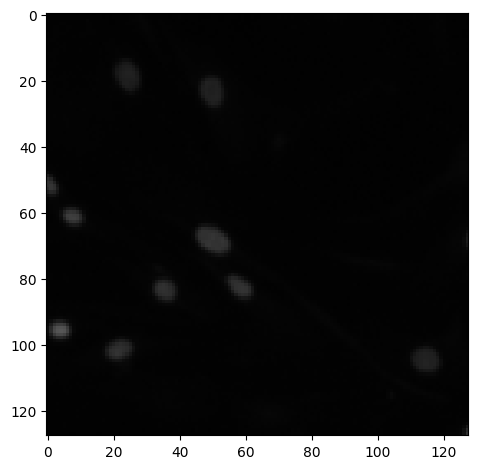

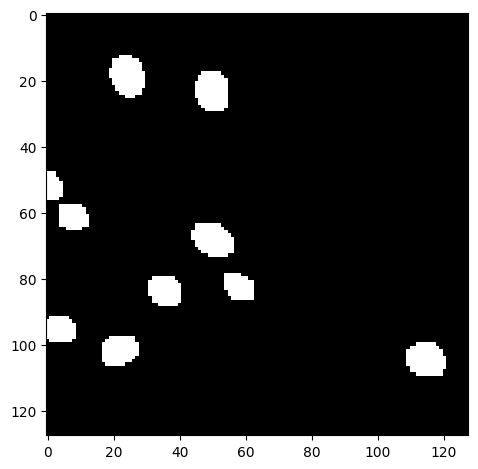

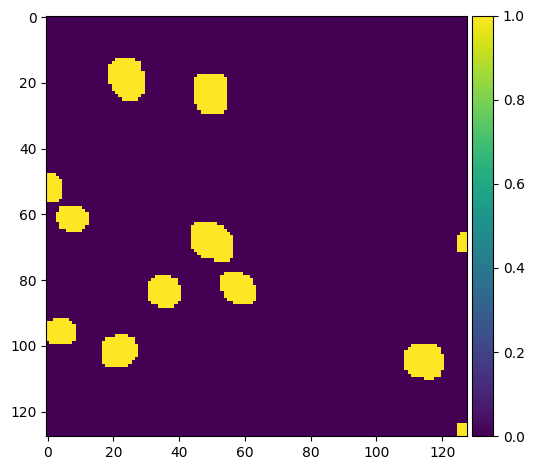

In [15]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()